In [1]:
import pandas as pd
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

from dataflow import df_train, df_test, df_geography, df_product



In [2]:
import torch 

c:\Users\Hưng Tăng\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\utils\_pytree.py:185: FutureWarning: optree is installed but the version is too old to support PyTorch Dynamo in C++ pytree. C++ pytree support is disabled. Please consider upgrading optree using `python3 -m pip install --upgrade 'optree>=0.13.0'`.
  warnings.warn(


In [4]:
import sys
print("Python Interpreter Path:", sys.executable)


Python Interpreter Path: c:\Users\Hưng Tăng\AppData\Local\Programs\Python\Python312\python.exe


In [5]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

# Chuyển cột Date sang kiểu datetime
df_train['Date'] = pd.to_datetime(df_train['Date'], errors='coerce')
df_test['Date'] = pd.to_datetime(df_test['Date'], errors='coerce')

# Xử lý lỗi nếu có giá trị NaT
df_train.dropna(subset=['Date'], inplace=True)
df_test.dropna(subset=['Date'], inplace=True)

# Tính số ngày kể từ ngày đầu tiên trong tập train
min_date = df_train['Date'].min()
df_train['Date'] = (df_train['Date'] - min_date).dt.days
df_test['Date'] = (df_test['Date'] - min_date).dt.days

# Chia df_train thành train (80%) và val (20%)
df_train, df_val = train_test_split(df_train, test_size=0.2, shuffle=True, random_state=42)

# Chọn features và labels
features = ['ProductID', 'Date', 'Zip', 'COGS']
targets = ['Units', 'Revenue']

# Chuẩn hóa dữ liệu
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

X_train = scaler_X.fit_transform(df_train[features])
X_val = scaler_X.transform(df_val[features])
X_test = scaler_X.transform(df_test[features])  # Dùng tập test để dự đoán

y_train = scaler_y.fit_transform(df_train[targets])
y_val = scaler_y.transform(df_val[targets])
y_test = scaler_y.transform(df_test[targets])  # Dùng để đánh giá mô hình


In [6]:
def create_sequences(X, y, time_steps=10):
    X_seq, y_seq = [], []
    for i in range(len(X) - time_steps):
        X_seq.append(X[i:i+time_steps])
        y_seq.append(y[i+time_steps])
    return np.array(X_seq), np.array(y_seq)

time_steps = 20  # Dùng 20 ngày trước đó để dự đoán ngày tiếp theo

X_train_seq, y_train_seq = create_sequences(X_train, y_train, time_steps)
X_val_seq, y_val_seq = create_sequences(X_val, y_val, time_steps)
X_test_seq, y_test_seq = create_sequences(X_test, y_test, time_steps)  # Tập này sẽ dùng để dự đoán


In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

# 🔹 Định nghĩa mô hình LSTM
class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim1=64, hidden_dim2=32, output_dim=2):
        super(LSTMModel, self).__init__()
        self.lstm1 = nn.LSTM(input_dim, hidden_dim1, batch_first=True)
        self.lstm2 = nn.LSTM(hidden_dim1, hidden_dim2, batch_first=True)
        self.dropout = nn.Dropout(0.2)
        self.fc = nn.Linear(hidden_dim2, output_dim)
    
    def forward(self, x):
        x, _ = self.lstm1(x)
        x = self.dropout(x)
        x, _ = self.lstm2(x)
        x = self.dropout(x[:, -1, :])  # Lấy giá trị cuối cùng của chuỗi
        x = self.fc(x)
        return x

# 🔹 Hàm loss tách riêng Units và Revenue
def custom_loss(y_pred, y_true):
    mse = nn.MSELoss()
    loss_units = mse(y_pred[:, 0], y_true[:, 0])
    loss_revenue = mse(y_pred[:, 1], y_true[:, 1])
    return loss_units + loss_revenue

# 🔹 Chuyển dữ liệu sang tensor
X_train_tensor = torch.tensor(X_train_seq, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train_seq, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val_seq, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val_seq, dtype=torch.float32)

# 🔹 Dataloader
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# 🔹 Khởi tạo mô hình
input_dim = X_train_seq.shape[2]
model = LSTMModel(input_dim)
optimizer = optim.Adam(model.parameters(), lr=0.001)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# 🔹 Callback in loss
for epoch in range(10):
    model.train()
    total_loss = 0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        y_pred = model(X_batch)
        loss = custom_loss(y_pred, y_batch)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    
    # 🔹 Đánh giá trên tập validation
    model.eval()
    val_loss_units, val_loss_revenue = 0, 0
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            y_pred = model(X_batch)
            val_loss_units += nn.MSELoss()(y_pred[:, 0], y_batch[:, 0]).item()
            val_loss_revenue += nn.MSELoss()(y_pred[:, 1], y_batch[:, 1]).item()
    
    print(f"📊 Epoch {epoch+1} | Train Loss = {total_loss/len(train_loader):.6f} | "
          f"Val Loss Units = {val_loss_units/len(val_loader):.6f}, "
          f"Val Loss Revenue = {val_loss_revenue/len(val_loader):.6f}")


📊 Epoch 1 | Train Loss = 0.000258 | Val Loss Units = 0.000059, Val Loss Revenue = 0.000190
📊 Epoch 2 | Train Loss = 0.000240 | Val Loss Units = 0.000059, Val Loss Revenue = 0.000186
📊 Epoch 3 | Train Loss = 0.000240 | Val Loss Units = 0.000059, Val Loss Revenue = 0.000187
📊 Epoch 4 | Train Loss = 0.000240 | Val Loss Units = 0.000059, Val Loss Revenue = 0.000187
📊 Epoch 5 | Train Loss = 0.000240 | Val Loss Units = 0.000059, Val Loss Revenue = 0.000186
📊 Epoch 6 | Train Loss = 0.000240 | Val Loss Units = 0.000060, Val Loss Revenue = 0.000188
📊 Epoch 7 | Train Loss = 0.000240 | Val Loss Units = 0.000059, Val Loss Revenue = 0.000187
📊 Epoch 8 | Train Loss = 0.000240 | Val Loss Units = 0.000059, Val Loss Revenue = 0.000187
📊 Epoch 9 | Train Loss = 0.000240 | Val Loss Units = 0.000059, Val Loss Revenue = 0.000188
📊 Epoch 10 | Train Loss = 0.000240 | Val Loss Units = 0.000060, Val Loss Revenue = 0.000188


In [13]:
# 🔹 Chuyển dữ liệu sang tensor
X_test_tensor = torch.tensor(X_val_seq, dtype=torch.float32)
y_test_tensor = torch.tensor(y_val_seq, dtype=torch.float32)

# 🔹 Dataloader
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [20]:
import torch
import numpy as np
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error, r2_score

# Đưa mô hình vào chế độ đánh giá (Evaluation mode)
with torch.no_grad():
    model.eval()
    y_pred = []
    y_true = []
    
    for X_batch, y_batch in test_loader:
        X_batch = X_batch.to(device)
        y_batch = y_batch.cpu().numpy()  # Chuyển y thật về CPU
        
        y_pred_batch = model(X_batch).cpu().numpy()  # Chuyển kết quả về CPU
        
        y_pred.append(y_pred_batch)
        y_true.append(y_batch)
        
# Chuyển danh sách thành mảng numpy
y_pred = np.concatenate(y_pred, axis=0)
y_true = np.concatenate(y_true, axis=0)

# 📌 Kiểm tra kích thước để tránh lỗi IndexError
print(f"y_pred.shape: {y_pred.shape}, y_true.shape: {y_true.shape}")

# Chuyển dữ liệu về giá trị gốc
y_pred = scaler_y.inverse_transform(y_pred)
y_true = scaler_y.inverse_transform(y_true)

# Tách dữ liệu dự đoán cho Units và Revenue
y_pred_units, y_pred_revenue = y_pred[:, 0], y_pred[:, 1]
y_true_units, y_true_revenue = y_true[:, 0], y_true[:, 1]

# 📌 Tính MAPE, RMSE, R²
mape_units = mean_absolute_percentage_error(y_true_units, y_pred_units)
mape_revenue = mean_absolute_percentage_error(y_true_revenue, y_pred_revenue)

rmse_units = np.sqrt(mean_squared_error(y_true_units, y_pred_units))
rmse_revenue = np.sqrt(mean_squared_error(y_true_revenue, y_pred_revenue))

r2_units = r2_score(y_true_units, y_pred_units)
r2_revenue = r2_score(y_true_revenue, y_pred_revenue)

# 📊 In kết quả
print(f"✅ MAPE Units = {mape_units:.4f}, MAPE Revenue = {mape_revenue:.4f}")
print(f"✅ RMSE Units = {rmse_units:.2f}, RMSE Revenue = {rmse_revenue:.2f}")
print(f"✅ R² Units = {r2_units:.4f}, R² Revenue = {r2_revenue:.4f}")


y_pred.shape: (180293, 2), y_true.shape: (180293, 2)
✅ MAPE Units = 0.0865, MAPE Revenue = 1.1955
✅ RMSE Units = 0.33, RMSE Revenue = 4580.89
✅ R² Units = -0.0211, R² Revenue = -0.0087


In [17]:
#save model
torch.save(model.state_dict(), 'LSTM1_modeltorch.pth')

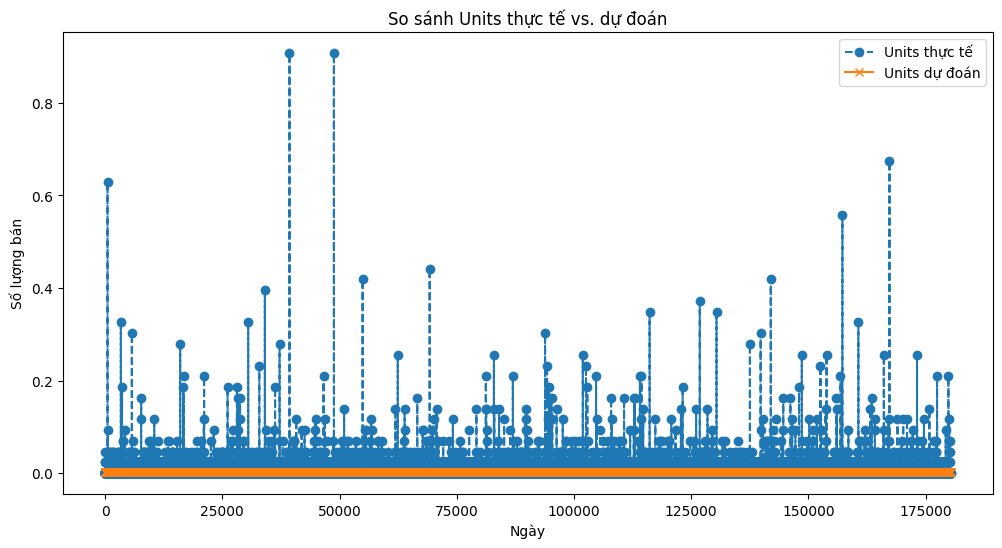

In [18]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(y_true_units, label="Units thực tế", marker='o', linestyle='dashed')
plt.plot(y_pred_units, label="Units dự đoán", marker='x')
plt.title("So sánh Units thực tế vs. dự đoán")
plt.xlabel("Ngày")
plt.ylabel("Số lượng bán")
plt.legend()
plt.show()


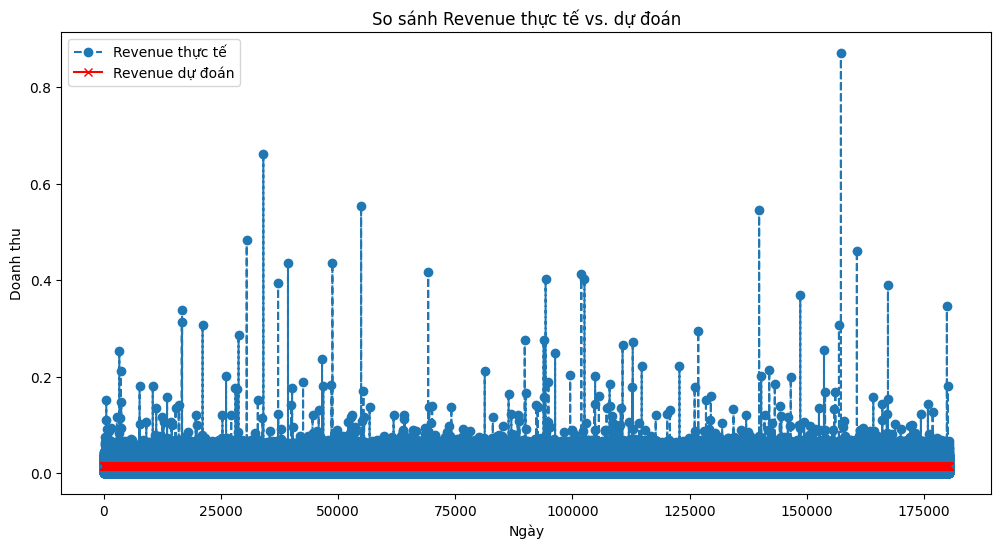

In [19]:
plt.figure(figsize=(12, 6))
plt.plot(y_true_revenue, label="Revenue thực tế", marker='o', linestyle='dashed')
plt.plot(y_pred_revenue, label="Revenue dự đoán", marker='x', color='red')
plt.title("So sánh Revenue thực tế vs. dự đoán")
plt.xlabel("Ngày")
plt.ylabel("Doanh thu")
plt.legend()
plt.show()
